Data shape: (1400, 12)

First 5 rows:
   user_id day_type transport_mode  distance_km  electricity_kwh  \
0        1  Weekend             EV         1.55             6.12   
1        1  Weekend           Walk        10.04             4.50   
2        1  Weekday           Walk        15.27             2.81   
3        1  Weekend           Walk         0.50            10.16   
4        1  Weekend           Walk         3.60             5.02   

   renewable_usage_pct food_type  screen_time_hours  waste_generated_kg  \
0                    0   Non-Veg                2.4                0.70   
1                    0     Mixed                4.1                0.54   
2                    0     Mixed                4.0                0.51   
3                    0     Mixed                6.3                0.73   
4                   50     Mixed                5.1                0.64   

   eco_actions  carbon_footprint_kg carbon_impact_level  
0            1                11.03         

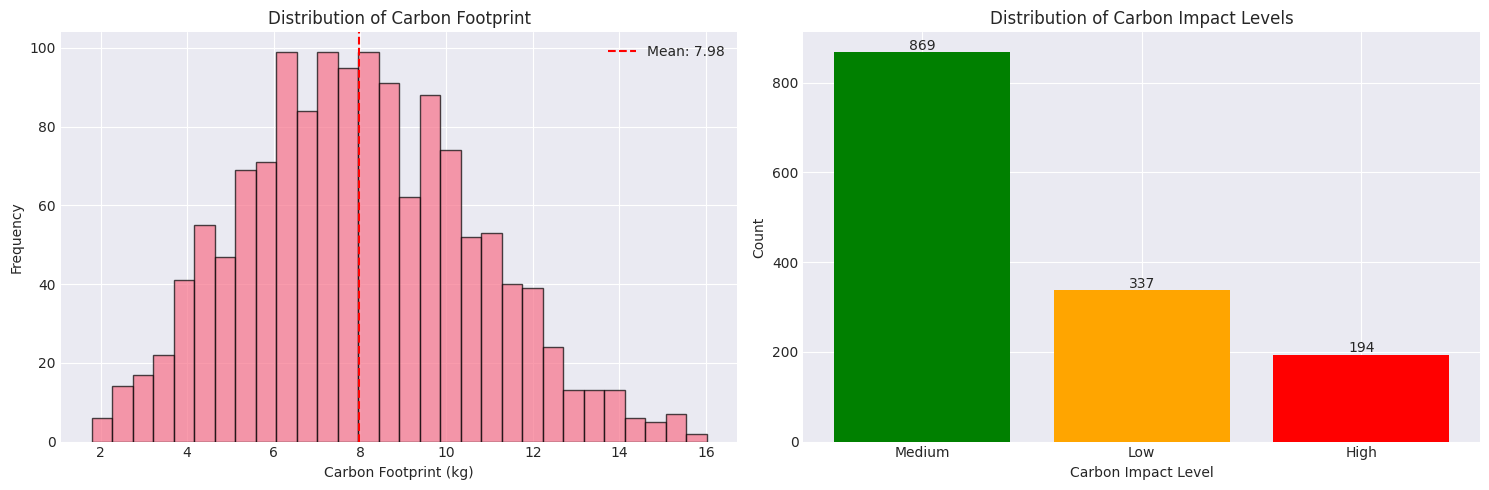

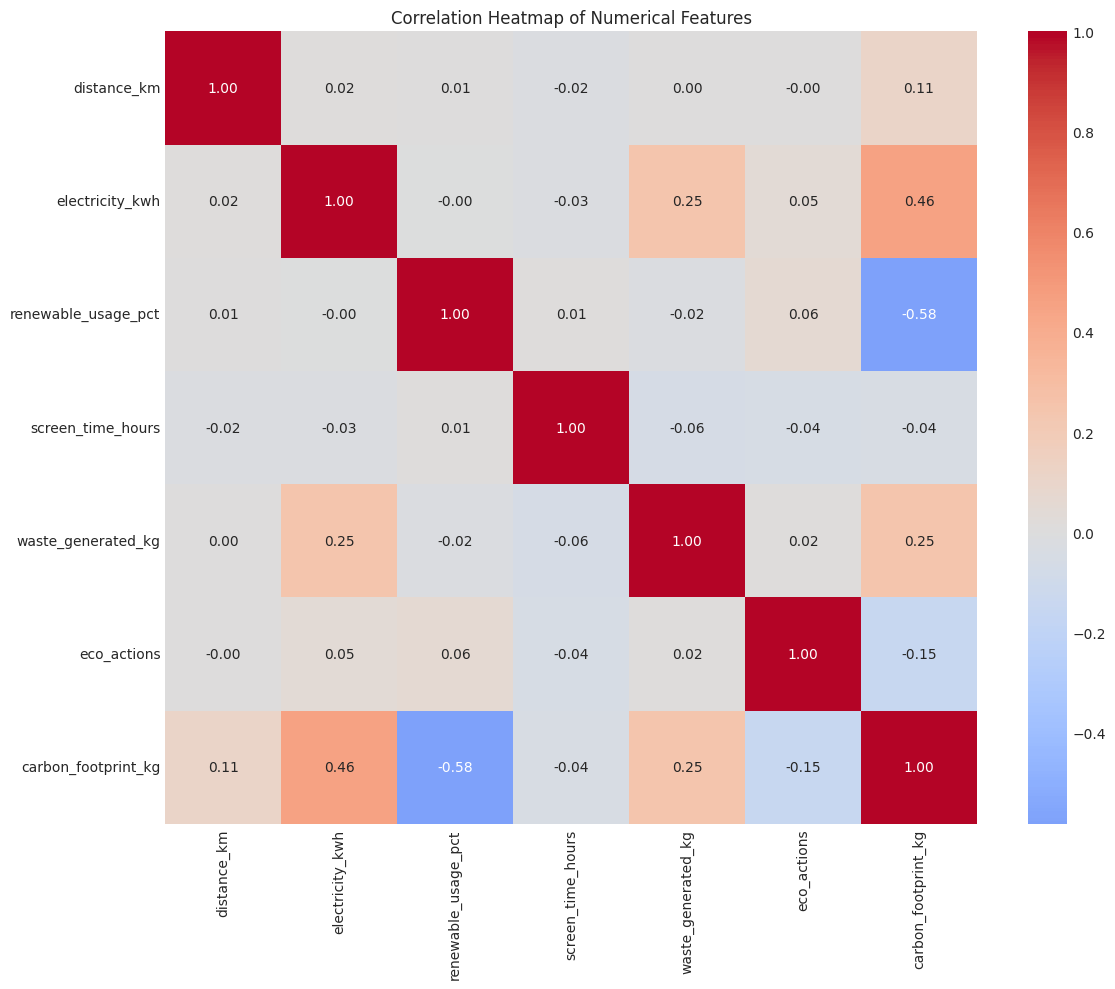

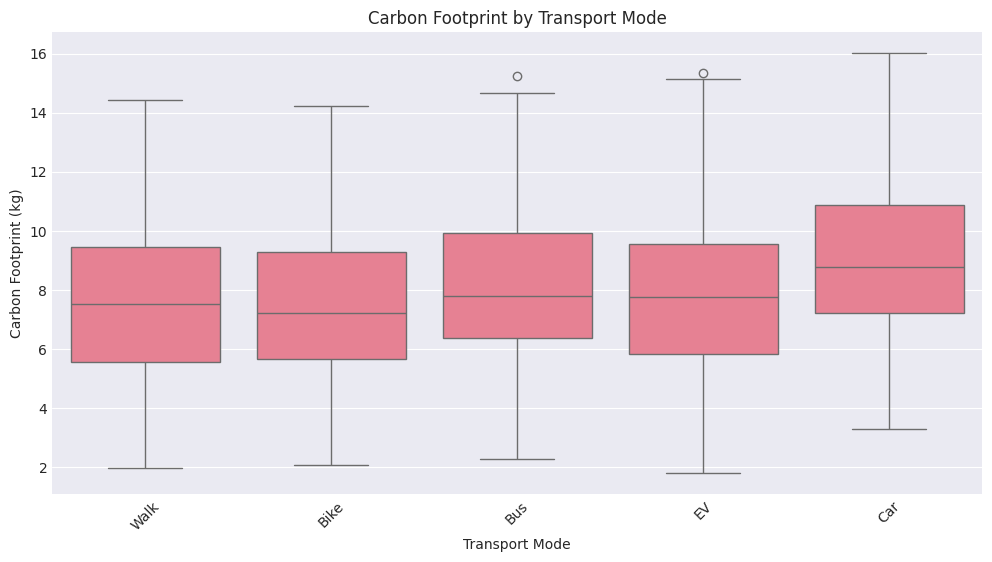

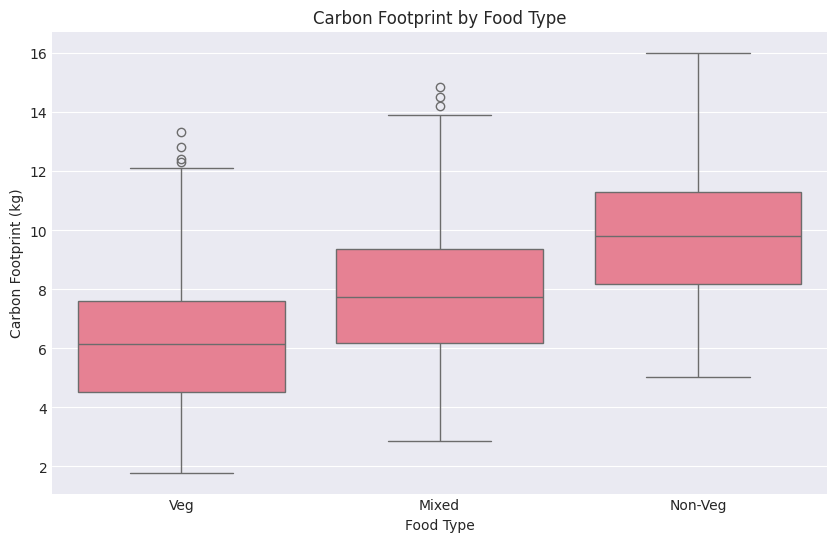

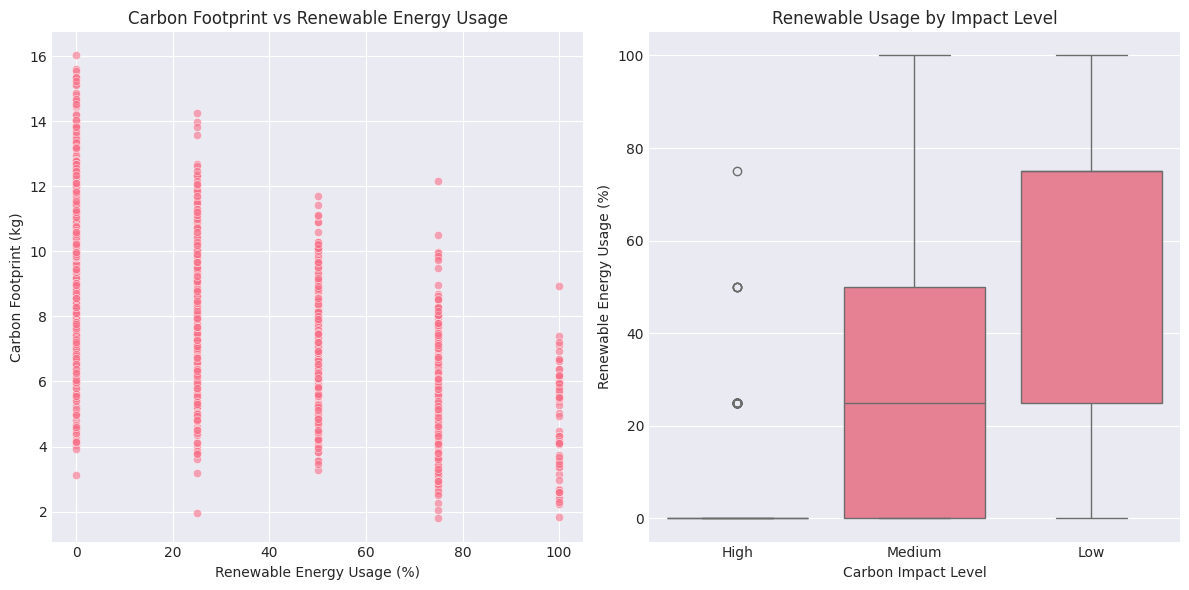

Numeric features: ['distance_km', 'electricity_kwh', 'renewable_usage_pct', 'screen_time_hours', 'waste_generated_kg', 'eco_actions']
Categorical features: ['day_type', 'transport_mode', 'food_type']
Training set size: 1120
Test set size: 280
Regression Model Performance:
MSE: 0.3559
RMSE: 0.5966
R² Score: 0.9445

Classification Model Performance:
Accuracy: 0.8786

Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.67      0.79        39
         Low       0.90      0.79      0.84        67
      Medium       0.86      0.96      0.91       174

    accuracy                           0.88       280
   macro avg       0.91      0.81      0.85       280
weighted avg       0.88      0.88      0.88       280



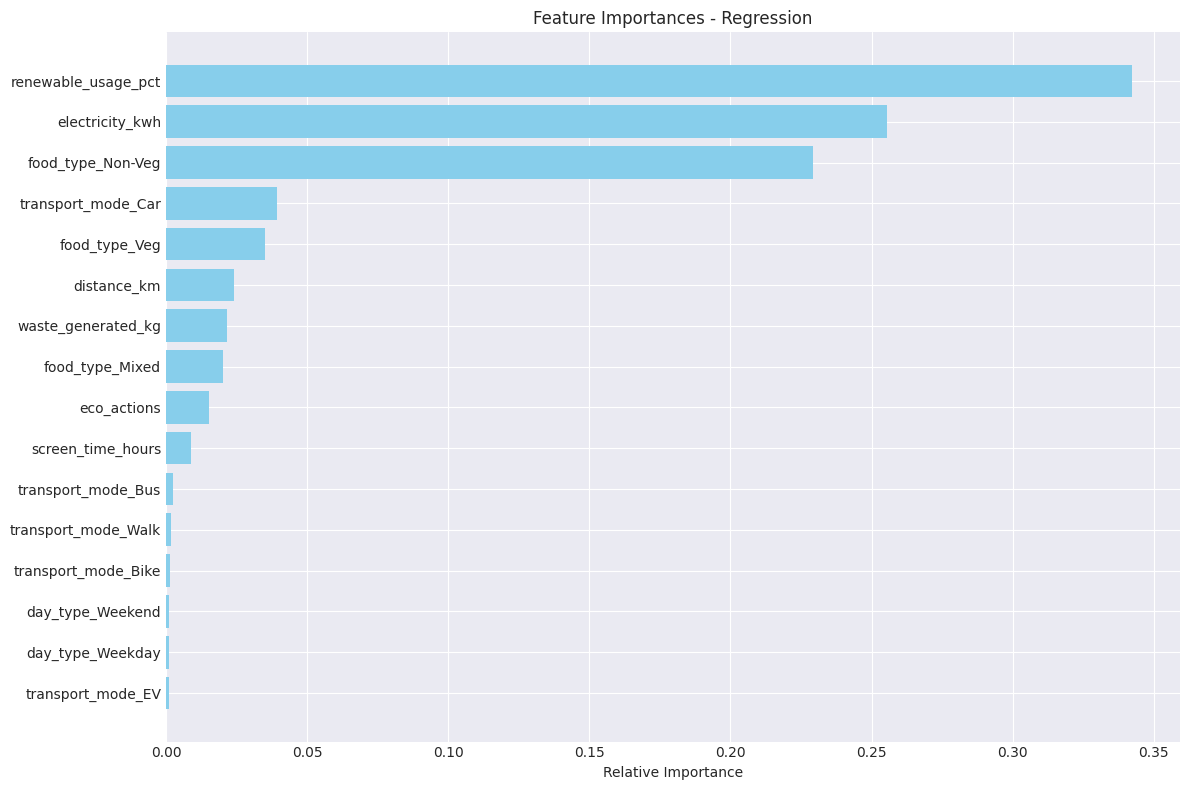

Models and preprocessor saved successfully!


In [1]:
# # Personal Carbon Footprint - Exploratory Data Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import pickle
import joblib

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# %%
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/dangoled/MLZoomcamp2025_Capstone3/refs/heads/main/data/raw/personal_carbon_footprint_behavior.csv')
print(f"Data shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

# %%
# Basic info
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nDescriptive Statistics:")
print(df.describe())

# %%
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# %%
# Unique values for categorical columns
categorical_cols = ['day_type', 'transport_mode', 'food_type', 'carbon_impact_level']
for col in categorical_cols:
    print(f"\n{col} unique values: {df[col].unique()}")
    print(f"{col} value counts:")
    print(df[col].value_counts())

# %%
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Carbon footprint distribution
axes[0].hist(df['carbon_footprint_kg'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Carbon Footprint (kg)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Carbon Footprint')
axes[0].axvline(df['carbon_footprint_kg'].mean(), color='red', linestyle='--', 
               label=f'Mean: {df["carbon_footprint_kg"].mean():.2f}')
axes[0].legend()

# Carbon impact level distribution
impact_counts = df['carbon_impact_level'].value_counts()
axes[1].bar(impact_counts.index, impact_counts.values, color=['green', 'orange', 'red'])
axes[1].set_xlabel('Carbon Impact Level')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Carbon Impact Levels')
for i, v in enumerate(impact_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

# %%
# Feature correlations
numeric_features = ['distance_km', 'electricity_kwh', 'renewable_usage_pct', 
                    'screen_time_hours', 'waste_generated_kg', 'eco_actions', 
                    'carbon_footprint_kg']

plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# %%
# Carbon footprint vs transport mode
plt.figure(figsize=(12, 6))
sns.boxplot(x='transport_mode', y='carbon_footprint_kg', data=df, 
            order=['Walk', 'Bike', 'Bus', 'EV', 'Car'])
plt.title('Carbon Footprint by Transport Mode')
plt.xlabel('Transport Mode')
plt.ylabel('Carbon Footprint (kg)')
plt.xticks(rotation=45)
plt.show()

# %%
# Carbon footprint vs food type
plt.figure(figsize=(10, 6))
sns.boxplot(x='food_type', y='carbon_footprint_kg', data=df, 
            order=['Veg', 'Mixed', 'Non-Veg'])
plt.title('Carbon Footprint by Food Type')
plt.xlabel('Food Type')
plt.ylabel('Carbon Footprint (kg)')
plt.show()

# %%
# Renewable usage impact
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='renewable_usage_pct', y='carbon_footprint_kg', data=df, alpha=0.6)
plt.title('Carbon Footprint vs Renewable Energy Usage')
plt.xlabel('Renewable Energy Usage (%)')
plt.ylabel('Carbon Footprint (kg)')

plt.subplot(1, 2, 2)
sns.boxplot(x='carbon_impact_level', y='renewable_usage_pct', data=df)
plt.title('Renewable Usage by Impact Level')
plt.xlabel('Carbon Impact Level')
plt.ylabel('Renewable Energy Usage (%)')

plt.tight_layout()
plt.show()

# %%
# Feature importance analysis using Random Forest
# Prepare features
X = df.drop(['user_id', 'carbon_footprint_kg', 'carbon_impact_level'], axis=1)
y_reg = df['carbon_footprint_kg']
y_clf = df['carbon_impact_level']

# Identify column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# %%
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# %%
# Split data
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# %%
# Train Random Forest for regression
rf_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_reg.fit(X_train, y_train_reg)
y_pred_reg = rf_reg.predict(X_test)

# Regression metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("Regression Model Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# %%
# Train Random Forest for classification
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_clf.fit(X_train, y_train_clf)
y_pred_clf = rf_clf.predict(X_test)

# Classification metrics
accuracy = accuracy_score(y_test_clf, y_pred_clf)
print("\nClassification Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf))

# %%
# Feature importance for regression
feature_names = (numeric_features + 
                 list(rf_reg.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_features)))

importances = rf_reg.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances - Regression')
plt.barh(range(min(20, len(indices))), importances[indices][:20][::-1], color='skyblue')
plt.yticks(range(min(20, len(indices))), [feature_names[i] for i in indices[:20][::-1]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# %%
# Save preprocessor and models
models_dir = '../models'
import os
os.makedirs(models_dir, exist_ok=True)

# Save preprocessor
with open(f'{models_dir}/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save regression model
with open(f'{models_dir}/regression_model.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

# Save classification model
with open(f'{models_dir}/classification_model.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

print("Models and preprocessor saved successfully!")